In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
import datasets

from safetensors import safe_open
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, set_seed
import numpy as np
from scipy.stats import spearmanr

In [15]:
d = "0a107cd4cea3bb5f618a8c87dad678f1693afc7ddf457b7781ac570e331cec3f.pt"
dir = "compressed_grads/4096/Qwen2ForCausalLM"
# glob all files with this name in subdirectories of the directory
files = [os.path.join(dp, f) for dp, dn, fn in os.walk(dir) for f in fn if f == d]

# compute filesize of all files
size = 0
for f in files:
    size += os.path.getsize(f)

print(f"Total size: {size/1024/1024:.2f} MiB")

Total size: 3.39 MiB


# Old Plots

In [ ]:
os.chdir("/lus/lfs1aip1/home/britllm/ksamway.britllm/workspace/FiLLM/src")

from utils import get_model_identifiers_from_yaml
from data_modules.tofu import (
    TOFU_RetainDatasetQA, TOFU_ForgetDatasetQA, datainf_collater,
    convert_raw_data_to_model_format
)
from localization.influence import second_order_influential_params

os.chdir("/lus/lfs1aip1/home/britllm/ksamway.britllm/workspace/FiLLM")

In [17]:
model_family="qwen2-1.5b"
model_path="models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250"
split="forget01"
data_path="locuslab/TOFU"
lam=0.1

set_seed(42)

In [18]:
model_cfg = get_model_identifiers_from_yaml(model_family)
model_id = model_cfg["hf_key"]

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

max_length = 500

config = AutoConfig.from_pretrained(model_id)

print("Loading from checkpoint")
model = AutoModelForCausalLM.from_pretrained(model_path, config=config, use_flash_attention_2=False, torch_dtype=torch.bfloat16, trust_remote_code = True)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Loading from checkpoint


In [116]:
ret_indices = range(10)
for_indices = range(10)

retain_dataset = TOFU_RetainDatasetQA(data_path, tokenizer=tokenizer, model_family=model_family, max_length=max_length, split=split, indices=ret_indices)
forget_dataset = TOFU_ForgetDatasetQA(data_path, tokenizer=tokenizer, model_family=model_family, max_length=max_length, split=split, indices=for_indices)

In [6]:
influence_full = second_order_influential_params(model, (retain_dataset, forget_dataset, datainf_collater), lam, compressed_size=None)

  0%|          | 0/10 [00:00<?, ?it/s]We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]
338it [00:21, 15.78it/s]


In [7]:
compressed_power=8
influence_compressed = second_order_influential_params(model, (retain_dataset, forget_dataset, datainf_collater), lam, compressed_size=2**compressed_power, cache_compressed_grads=False)
# influence_compressed_cached = second_order_influential_params(model, (retain_dataset, forget_dataset, datainf_collater), lam, compressed_size=2**compressed_power, cache_compressed_grads=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:57<00:00, 11.79s/it]
338it [00:00, 547.05it/s]


In [46]:
powers = [16, 14, 12, 10, 8]
ics = []
corrs = []
for cpow in powers:
    ic = second_order_influential_params(model, (retain_dataset, forget_dataset, datainf_collater), lam, compressed_size=2**cpow, cache_compressed_grads=False)
    ics.append(ic)

# save the compression rankings
for i, ic in enumerate(ics):
    with open(f"x/k2p{powers[i]}.txt", "w") as f:
        for p in ic:
            f.write(f"{p}\n")

# save full ranking
with open("x/full.txt", "w") as f:
    for p in influence_full:
        f.write(f"{p}\n")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:56<00:00, 11.67s/it]
338it [00:19, 17.16it/s]


(k=2**16) Spearman's Rank Correlation: 0.8804495292092742


100%|██████████| 10/10 [01:55<00:00, 11.58s/it]
338it [00:00, 525.69it/s]


(k=2**14) Spearman's Rank Correlation: 0.8633593196314671


100%|██████████| 10/10 [01:55<00:00, 11.52s/it]
338it [00:00, 522.02it/s]


(k=2**12) Spearman's Rank Correlation: 0.8585602915865143


100%|██████████| 10/10 [01:55<00:00, 11.59s/it]
338it [00:00, 542.60it/s]


(k=2**10) Spearman's Rank Correlation: 0.8197833350207553


100%|██████████| 10/10 [01:55<00:00, 11.59s/it]
338it [00:00, 498.14it/s]


(k=2**8) Spearman's Rank Correlation: 0.749377341297965


In [19]:
# open results
powers = [16, 14, 12, 10, 8]
corrs = []
ics = []
for i, _ in enumerate(powers):
    with open(f"x/k2p{powers[i]}.txt", "r") as f:
        ics.append(f.read().split("\n"))

with open("x/full.txt", "r") as f:
    influence_full = f.read().split("\n")

for ic, cpow in zip(ics, powers):
    p_full = [p for p in influence_full if ".mlp" in p]
    p_compressed = [p for p in ic if ".mlp" in p]
    index_map = {p: i for i, p in enumerate(p_full)}

    original_i = [index_map[v] for v in p_compressed]
    modified_i = [p_compressed.index(v) for v in p_compressed]

    spearman_corr, _ = spearmanr(original_i, modified_i)
    corrs.append(spearman_corr)
    print(f"(k=2**{cpow}) Spearman's Rank Correlation: {spearman_corr}")

(k=2**16) Spearman's Rank Correlation: 0.8804495292092742
(k=2**14) Spearman's Rank Correlation: 0.8633593196314671
(k=2**12) Spearman's Rank Correlation: 0.8585602915865143
(k=2**10) Spearman's Rank Correlation: 0.8197833350207553
(k=2**8) Spearman's Rank Correlation: 0.749377341297965


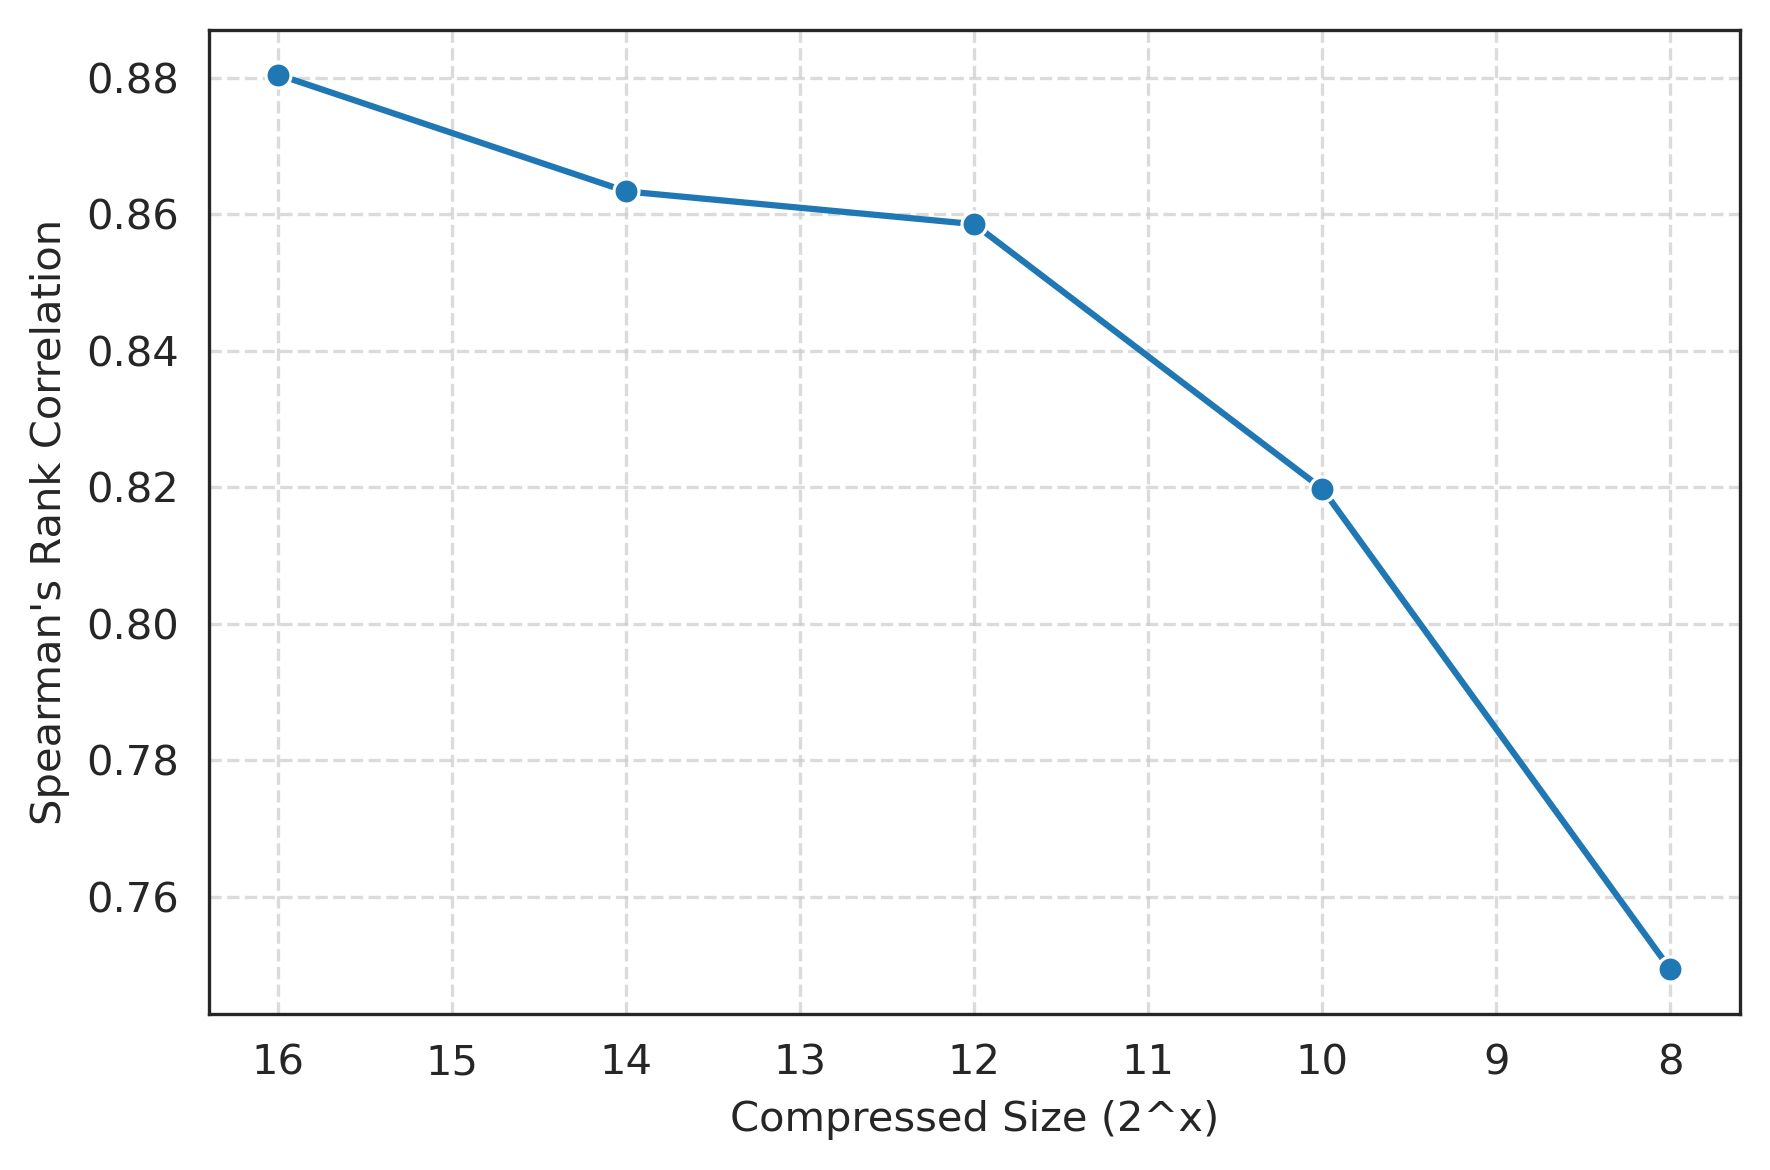

In [20]:
# plot the results
sns.set_style('white')
fig, ax = plt.subplots(dpi=300, figsize=(6, 4))
sns.lineplot(x=powers, y=corrs, ax=ax, marker='o')
ax.set_xlabel("Compressed Size (2^x)")
ax.set_ylabel("Spearman's Rank Correlation")
ax.invert_xaxis()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# fig.savefig("figures/spearman_correlation.svg", format='svg', bbox_inches='tight')

In [23]:
layer_colors = {
    'mlp.up_proj': 'lightsteelblue',
    'mlp.gate_proj': 'cornflowerblue',
    'mlp.down_proj': 'royalblue',

    'self_attn.q_proj': 'olivedrab',
    'self_attn.k_proj': 'limegreen',
    'self_attn.v_proj': 'darkgreen',
    'self_attn.o_proj': 'springgreen',

    'post_attention_layernorm': 'indianred',
    'input_layernorm': 'lightcoral',

    'embed_tokens': 'yellow',
    '.norm': 'magenta'
}

def categorize_layer(layer_name):
    for key in layer_colors.keys():
        if key in layer_name:
            return key

Spearman's Rank Correlation: 0.010216932483841281


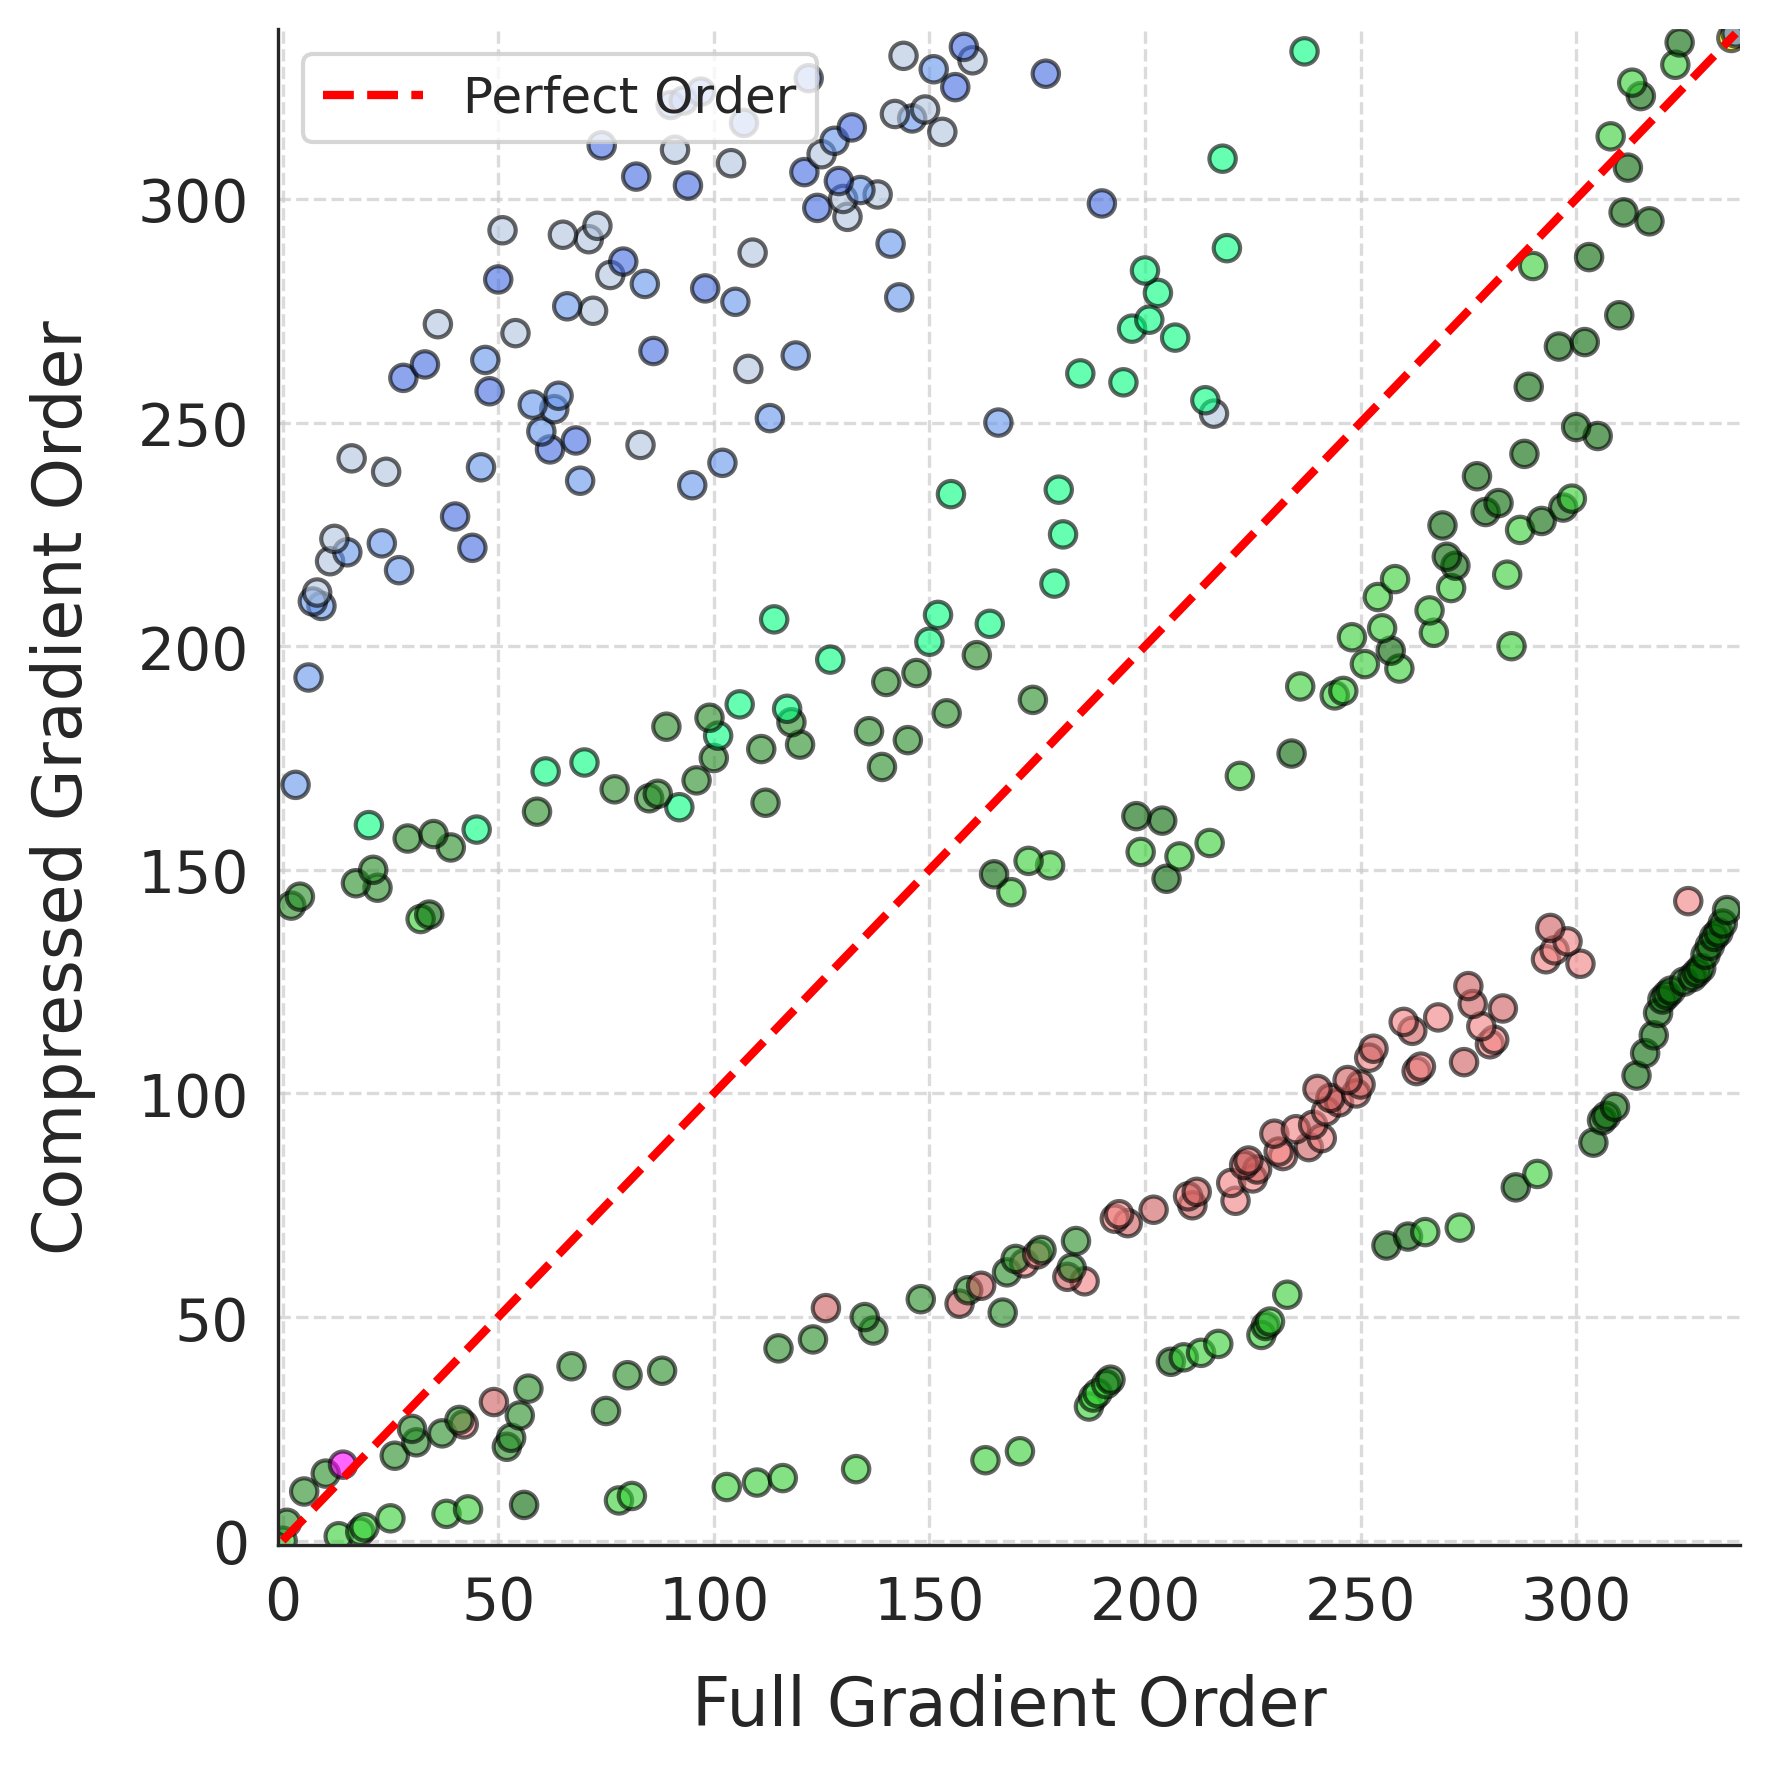

In [42]:
params_full = influence_full
params_compressed = influence_compressed

layer_categories = {layer: categorize_layer(layer) for layer in params_full}
index_map = {p: i for i, p in enumerate(params_full)}

original_indices = []
modified_indices = []
colors = []

for v in params_compressed:
    original_indices.append(index_map[v])
    modified_indices.append(params_compressed.index(v))
    layer_category = layer_categories[v]
    colors.append(layer_colors[layer_category])

sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

scatter = ax.scatter(original_indices, modified_indices, c=colors, marker='o', edgecolor='black', s=40, alpha=0.6, label='_nolegend_')
ideal_line, = ax.plot([0, len(params_full)-1], [0, len(params_full)-1], 'r--', lw=2, label='Perfect Order')

ax.set_xlabel('Full Gradient Order', fontsize=16, labelpad=10)
ax.set_ylabel('Compressed Gradient Order', fontsize=16, labelpad=10)
ax.set_xlim(-1, len(params_full))
ax.set_ylim(-1, len(params_full))
ax.grid(True, linestyle='--', alpha=0.7)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(handles=[ideal_line], loc='upper left', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

spearman_corr, _ = spearmanr(original_indices, modified_indices)
print(f"Spearman's Rank Correlation: {spearman_corr}")


plt.show()

# fig.savefig(f"figures/all-layers_ordering_10r10f_2p{compressed_power}.svg")

Spearman's Rank Correlation: -0.10818103096331744


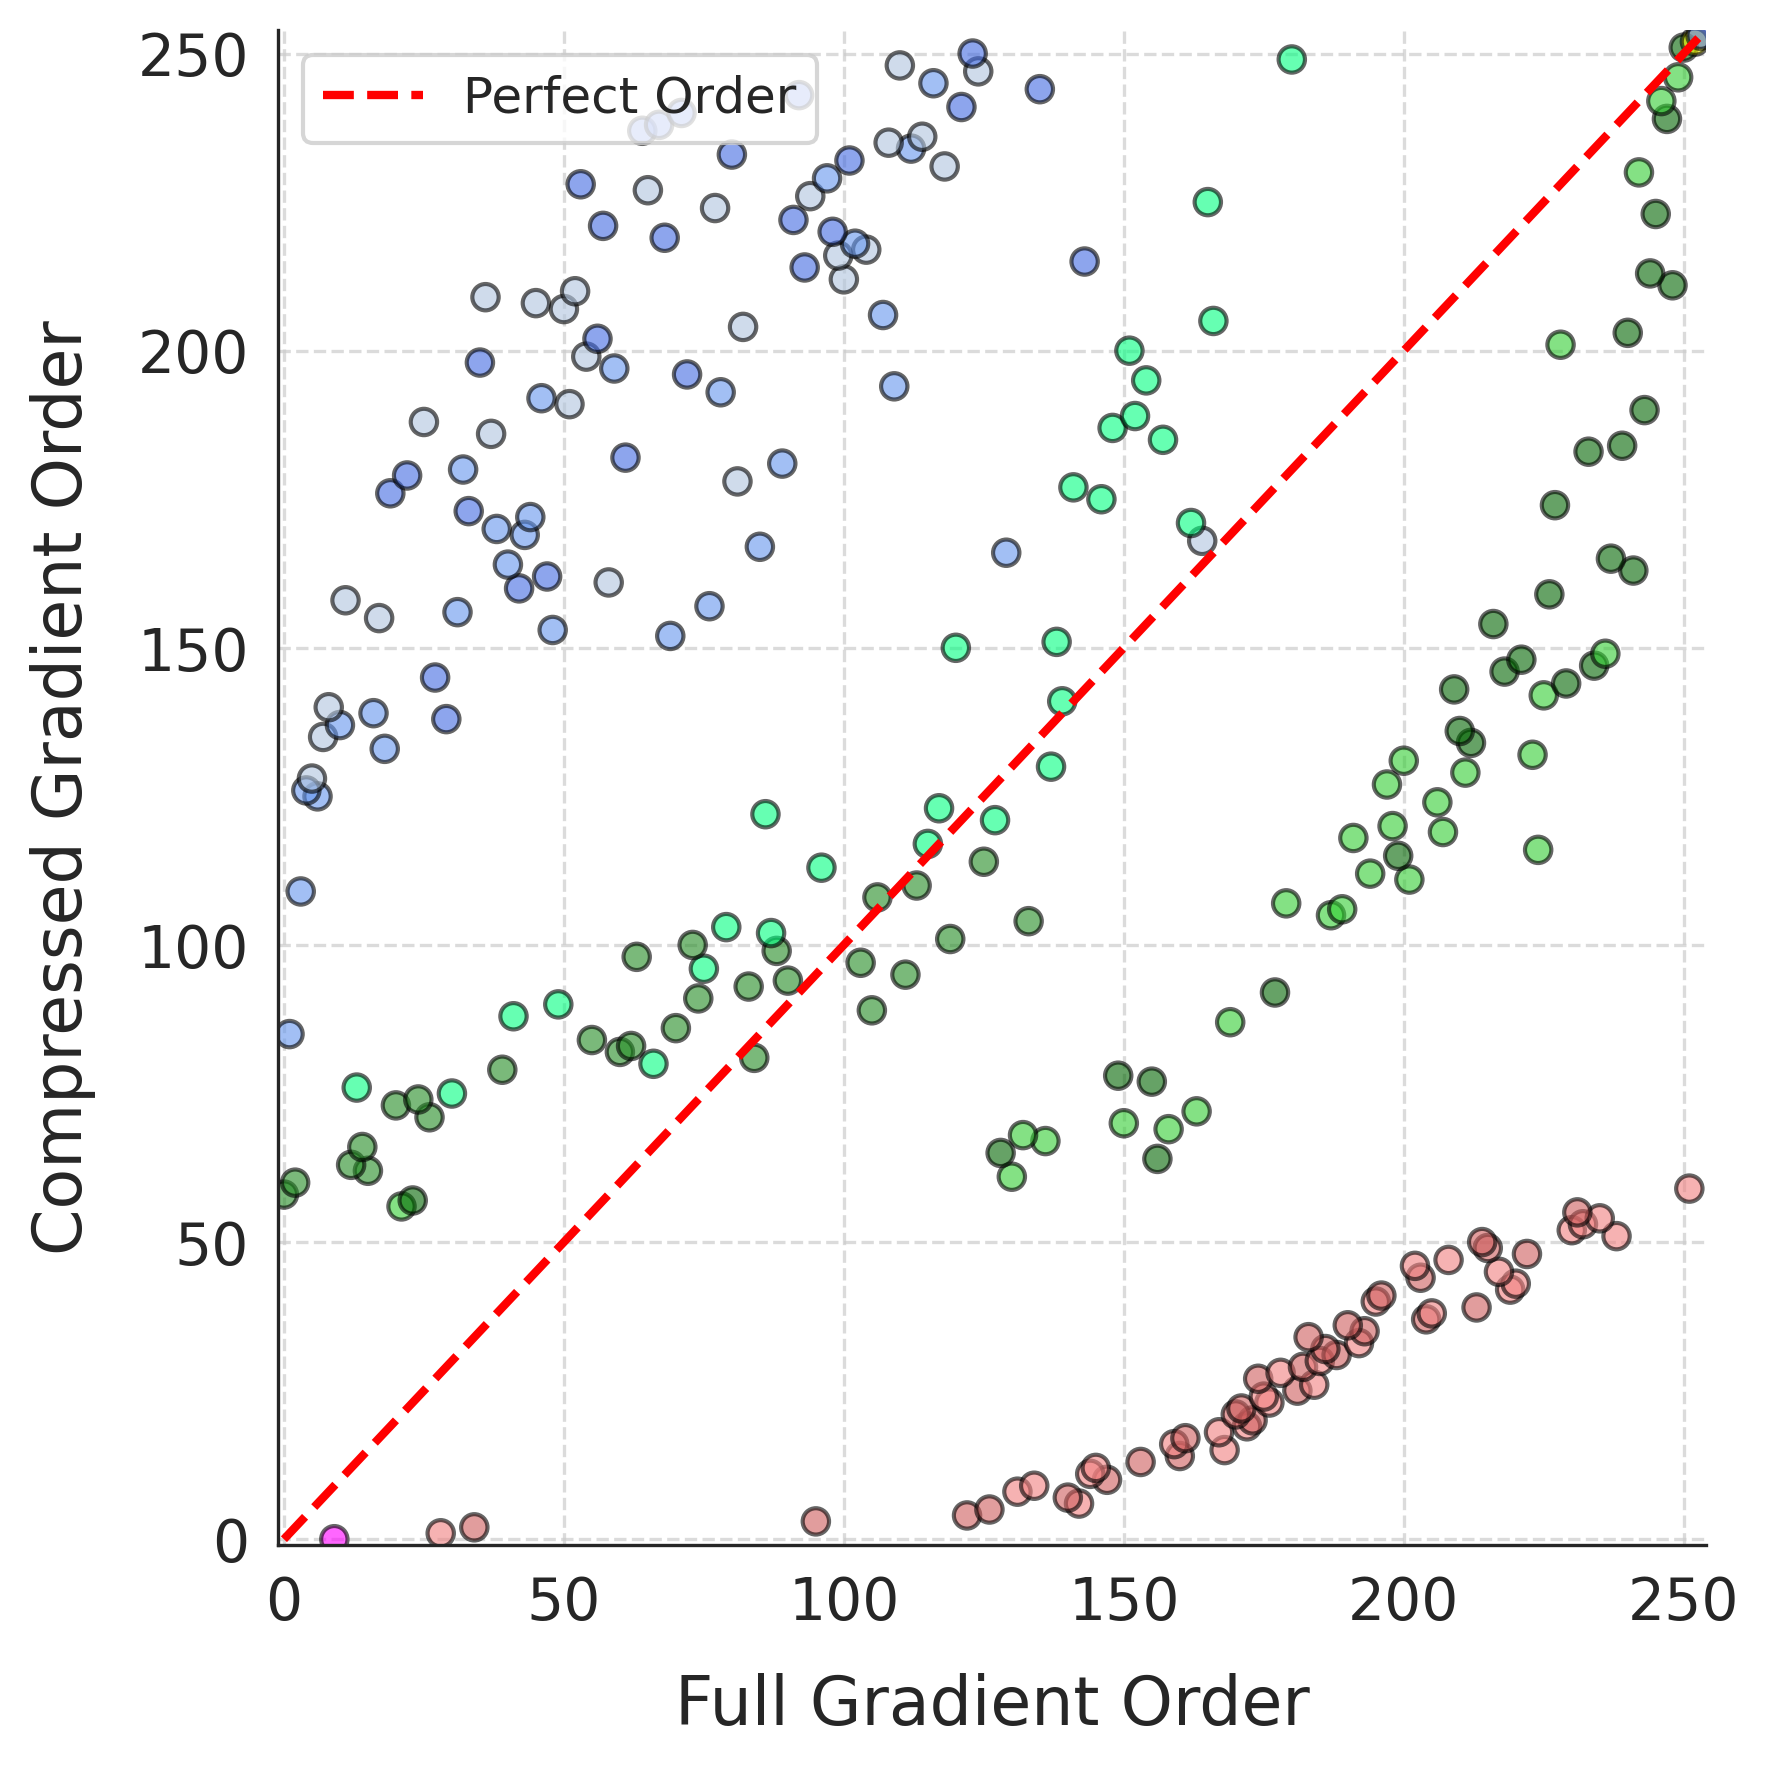

In [41]:
params_full = [p for p in influence_full if ".weight" in p]
params_compressed = [p for p in influence_compressed if ".weight" in p]

layer_categories = {layer: categorize_layer(layer) for layer in params_full}
index_map = {p: i for i, p in enumerate(params_full)}

original_indices = []
modified_indices = []
colors = []

for v in params_compressed:
    original_indices.append(index_map[v])
    modified_indices.append(params_compressed.index(v))
    layer_category = layer_categories[v]
    colors.append(layer_colors[layer_category])

sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

scatter = ax.scatter(original_indices, modified_indices, c=colors, marker='o', edgecolor='black', s=40, alpha=0.6, label='_nolegend_')
ideal_line, = ax.plot([0, len(params_full)-1], [0, len(params_full)-1], 'r--', lw=2, label='Perfect Order')

ax.set_xlabel('Full Gradient Order', fontsize=16, labelpad=10)
ax.set_ylabel('Compressed Gradient Order', fontsize=16, labelpad=10)
ax.set_xlim(-1, len(params_full))
ax.set_ylim(-1, len(params_full))
ax.grid(True, linestyle='--', alpha=0.7)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(handles=[ideal_line], loc='upper left', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

spearman_corr, _ = spearmanr(original_indices, modified_indices)
print(f"Spearman's Rank Correlation: {spearman_corr}")

plt.show()
# fig.savefig(f"figures/weights_ordering_10r10f_2p{compressed_power}.svg")

Spearman's Rank Correlation: 0.749377341297965


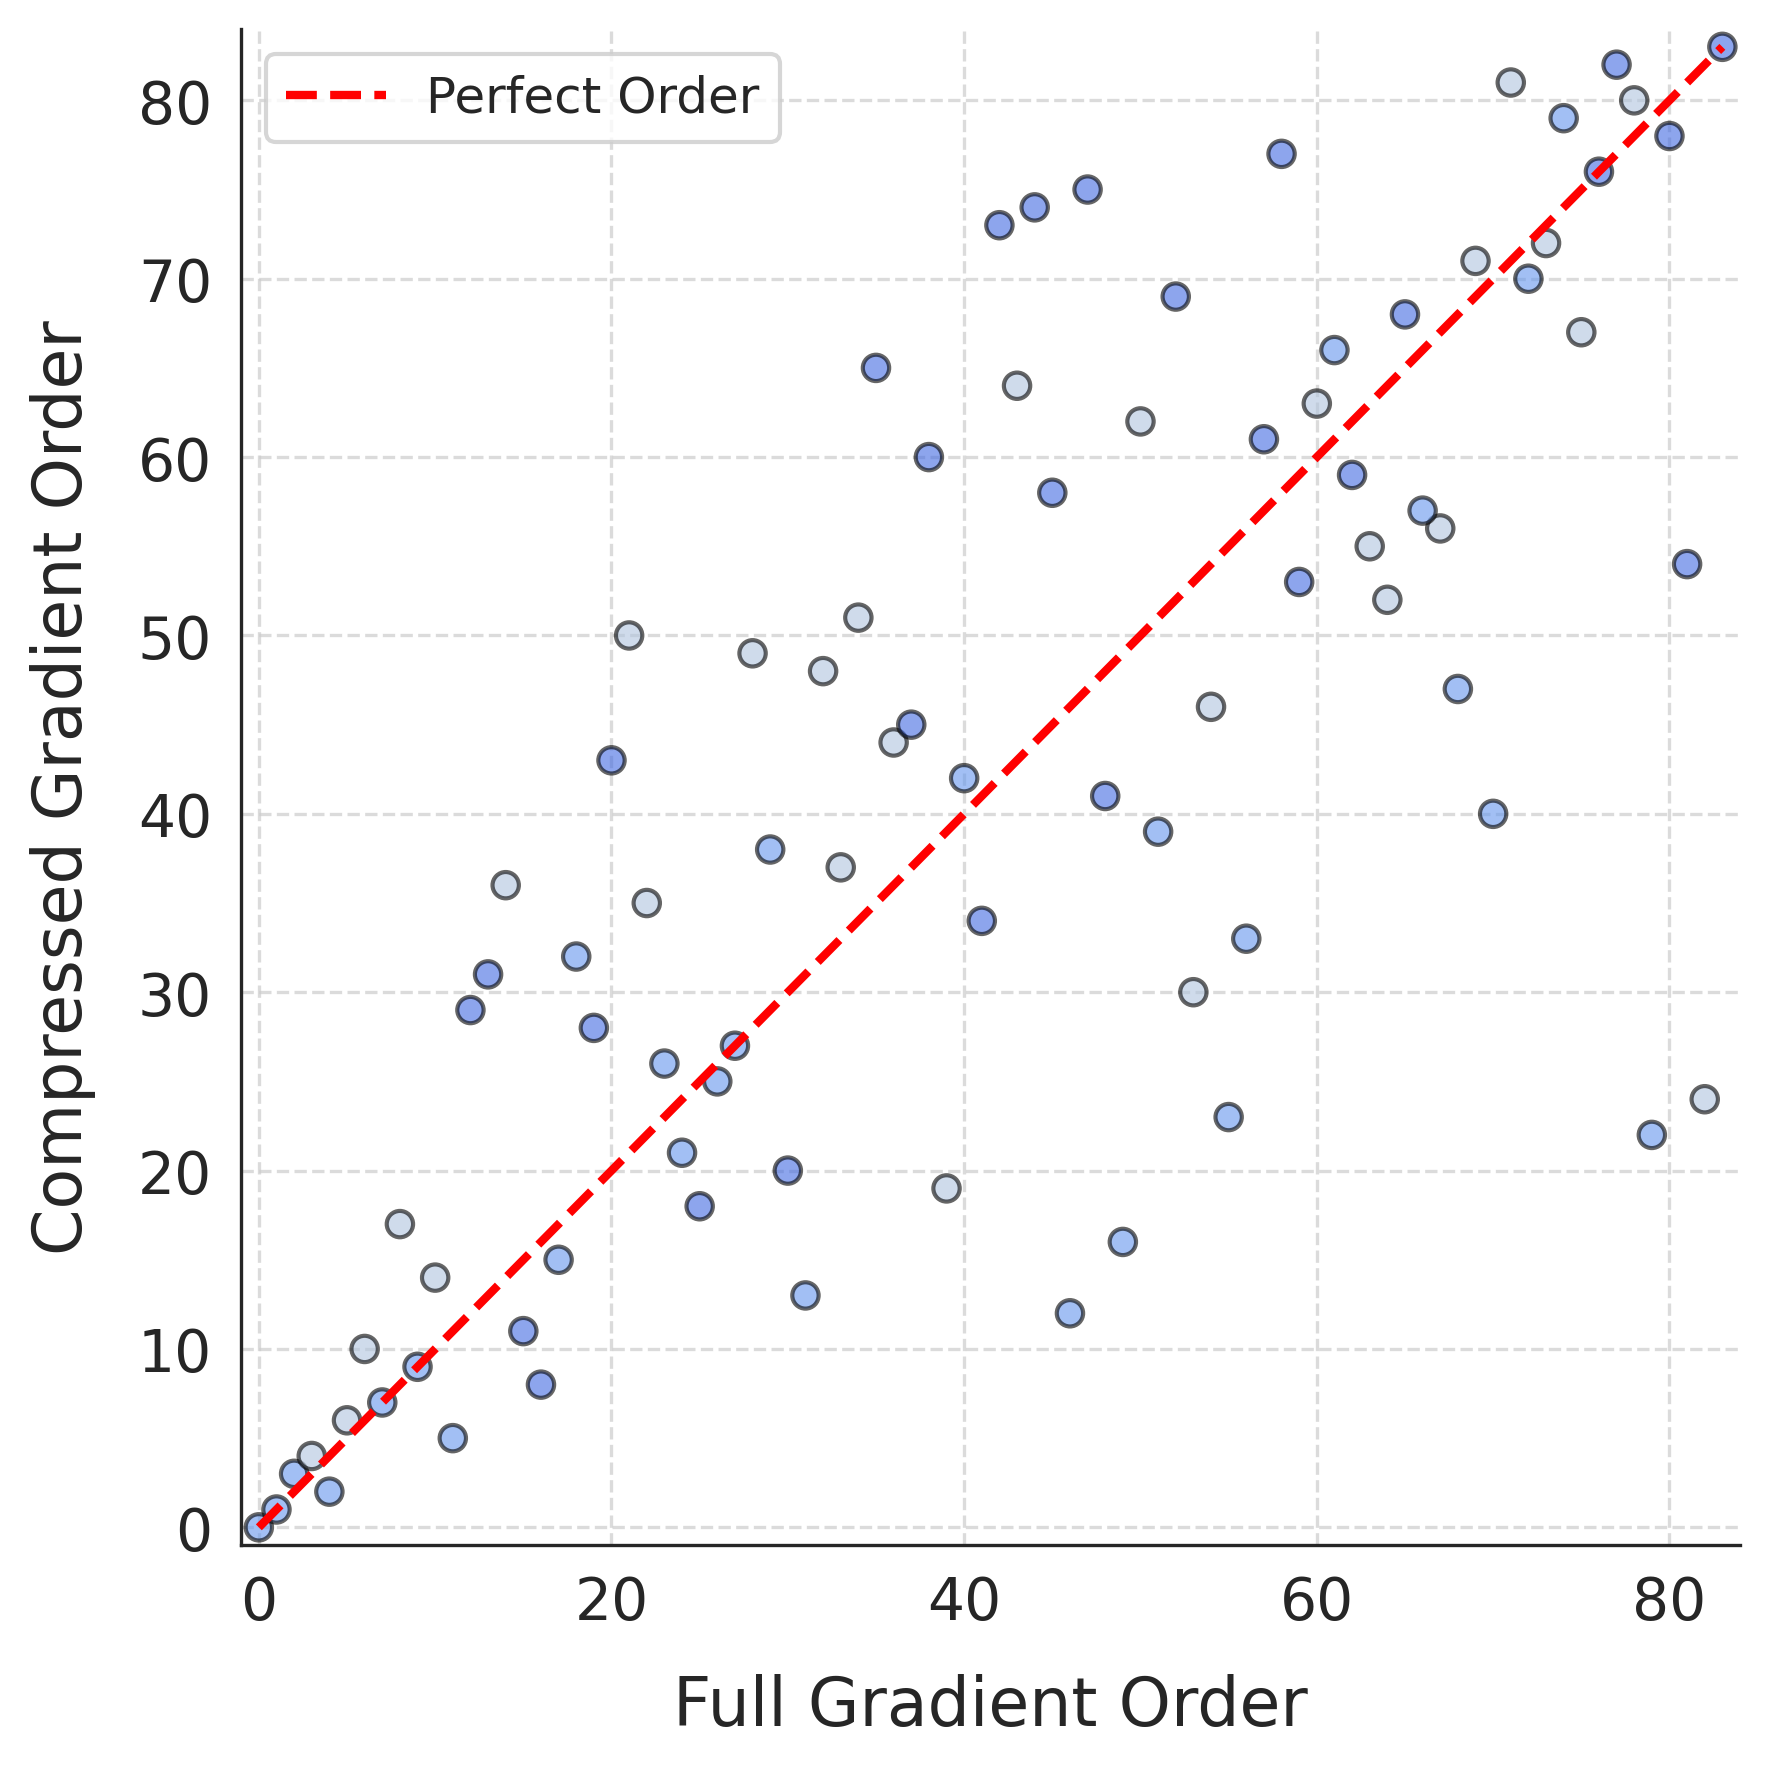

In [43]:
params_full = [p for p in influence_full if ".mlp" in p]
params_compressed = [p for p in influence_compressed if ".mlp" in p]

layer_categories = {layer: categorize_layer(layer) for layer in params_full}
index_map = {p: i for i, p in enumerate(params_full)}

original_indices = []
modified_indices = []
colors = []

for v in params_compressed:
    original_indices.append(index_map[v])
    modified_indices.append(params_compressed.index(v))
    layer_category = layer_categories[v]
    colors.append(layer_colors[layer_category])

sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

scatter = ax.scatter(original_indices, modified_indices, c=colors, marker='o', edgecolor='black', s=40, alpha=0.6, label='_nolegend_')
ideal_line, = ax.plot([0, len(params_full)-1], [0, len(params_full)-1], 'r--', lw=2, label='Perfect Order')

ax.set_xlabel('Full Gradient Order', fontsize=16, labelpad=10)
ax.set_ylabel('Compressed Gradient Order', fontsize=16, labelpad=10)
ax.set_xlim(-1, len(params_full))
ax.set_ylim(-1, len(params_full))
ax.grid(True, linestyle='--', alpha=0.7)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(handles=[ideal_line], loc='upper left', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

spearman_corr, _ = spearmanr(original_indices, modified_indices)
print(f"Spearman's Rank Correlation: {spearman_corr}")

plt.show()
# fig.savefig(f"figures/mlp_ordering_10r10f_2p{compressed_power}.svg")

In [ ]:
params_full = [p for p in influence_full if ".self_attn" in p]
params_compressed = [p for p in influence_compressed if ".self_attn" in p]

layer_colors = {
    'mlp.up_proj': 'lightsteelblue',
    'mlp.gate_proj': 'cornflowerblue',
    'mlp.down_proj': 'royalblue',

    'self_attn.q_proj': 'forestgreen',
    'self_attn.k_proj': 'limegreen',
    'self_attn.v_proj': 'darkgreen',
    'self_attn.o_proj': 'springgreen',

    'post_attention_layernorm': 'indianred',
    'input_layernorm': 'lightcoral',

    'embed_tokens': 'yellow',
    '.norm': 'magenta'
}

def categorize_layer(layer_name):
    for key in layer_colors.keys():
        if key in layer_name:
            return key

layer_categories = {layer: categorize_layer(layer) for layer in params_full}


index_map = {p: i for i, p in enumerate(params_full)}

original_indices = []
modified_indices = []
colors = []

for v in params_compressed:
    original_indices.append(index_map[v])
    modified_indices.append(params_compressed.index(v))
    layer_category = layer_categories[v]
    colors.append(layer_colors[layer_category])

sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

scatter = ax.scatter(original_indices, modified_indices, c=colors, marker='o', edgecolor='black', s=40, alpha=0.6, label='_nolegend_')
ideal_line, = ax.plot([0, len(params_full)-1], [0, len(params_full)-1], 'r--', lw=2, label='Perfect Order')

ax.set_xlabel('Full Gradient Order', fontsize=16, labelpad=10)
ax.set_ylabel('Compressed Gradient Order', fontsize=16, labelpad=10)
ax.set_xlim(-1, len(params_full))
ax.set_ylim(-1, len(params_full))
ax.grid(True, linestyle='--', alpha=0.7)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(handles=[ideal_line], loc='upper left', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

spearman_corr, _ = spearmanr(original_indices, modified_indices)
print(f"Spearman's Rank Correlation: {spearman_corr}")

plt.show()
# fig.savefig(f"figures/self-attn_ordering_10r10f_2p{compressed_power}.svg")

In [13]:
[p for p in influence_full if "mlp" in p][:15]

['model.layers.0.mlp.gate_proj.weight',
 'model.layers.1.mlp.gate_proj.weight',
 'model.layers.2.mlp.gate_proj.weight',
 'model.layers.0.mlp.up_proj.weight',
 'model.layers.3.mlp.gate_proj.weight',
 'model.layers.1.mlp.up_proj.weight',
 'model.layers.2.mlp.up_proj.weight',
 'model.layers.4.mlp.gate_proj.weight',
 'model.layers.3.mlp.up_proj.weight',
 'model.layers.5.mlp.gate_proj.weight',
 'model.layers.4.mlp.up_proj.weight',
 'model.layers.6.mlp.gate_proj.weight',
 'model.layers.2.mlp.down_proj.weight',
 'model.layers.4.mlp.down_proj.weight',
 'model.layers.5.mlp.up_proj.weight']

In [14]:
[p for p in influence_compressed if "mlp" in p][:15]

['model.layers.0.mlp.gate_proj.weight',
 'model.layers.1.mlp.gate_proj.weight',
 'model.layers.3.mlp.gate_proj.weight',
 'model.layers.2.mlp.gate_proj.weight',
 'model.layers.0.mlp.up_proj.weight',
 'model.layers.6.mlp.gate_proj.weight',
 'model.layers.1.mlp.up_proj.weight',
 'model.layers.4.mlp.gate_proj.weight',
 'model.layers.0.mlp.down_proj.weight',
 'model.layers.5.mlp.gate_proj.weight',
 'model.layers.2.mlp.up_proj.weight',
 'model.layers.25.mlp.down_proj.weight',
 'model.layers.25.mlp.gate_proj.weight',
 'model.layers.8.mlp.gate_proj.weight',
 'model.layers.4.mlp.up_proj.weight']

# New plots

In [3]:
def get_params_safe(dir):
    # get .safetensors file
    safetensors_file = os.path.join(dir, "model.safetensors")
    with safe_open(safetensors_file, framework="pt") as f:
        params = {key: f.get_tensor(key) for key in f.keys()}

    if "qwen" in dir:
        custom_order = [
            "mlp.up_proj", "mlp.gate_proj", "mlp.down_proj",
            "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj",
            "input_layernorm", "post_attention_layernorm"
        ]
    elif "phi" in dir:
        custom_order = [
            "mlp.fc1", "mlp.fc2",
            "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.dense",
            "input_layernorm",
        ]

    def sort_key(key):
        if "lm_head" in key: return 9999, 9999
        if key == 'model.embed_tokens.weight': return -1, -1 # for Qwen
        if key == 'model.norm.weight': return 9998, 9998 # for Qwen
        if 'model.final_layernorm' in key: return 9998, 9998 # for Phi
        layer = int(key.split('.')[2])
        component = ".".join(key.split('.')[3:])
        return layer, next((i for i, c in enumerate(custom_order) if c in component), len(custom_order))

    params = dict(sorted(params.items(), key=lambda x: sort_key(x[0])))
    return params

def get_param_diff_norm(og_params, ft_params, sort=True):
    og_params = get_params_safe(og_params)
    ft_params = get_params_safe(ft_params)
    param_diff = {}
    for param_name in og_params.keys():
        diff = og_params[param_name] - ft_params[param_name]
        norm = torch.linalg.norm(diff)
        # norm = torch.abs(diff).mean()
        param_diff[param_name] = norm.item()
    param_diff = list(param_diff.items())
    if sort:
        param_diff = sorted(param_diff, key=lambda x: x[1], reverse=True)
        param_diff = [x[0] for x in param_diff]
    return param_diff

def open_params_file(path):
    with open(path, 'r') as f:
        return f.read().splitlines()

layer_colors = {
    'mlp.up_proj': 'lightsteelblue',
    'mlp.gate_proj': 'cornflowerblue',
    'mlp.down_proj': 'royalblue',

    'self_attn.q_proj': 'olivedrab',
    'self_attn.k_proj': 'limegreen',
    'self_attn.v_proj': 'darkgreen',
    'self_attn.o_proj': 'springgreen',

    'post_attention_layernorm': 'indianred',
    'input_layernorm': 'lightcoral',

    'embed_tokens': 'yellow',
    '.norm': 'magenta'
}

def categorize_layer(layer_name):
    for key in layer_colors.keys():
        if key in layer_name:
            return key

def plot_comparison(params_x, params_y, titles, in_scope=None, out_scope=None, reverse_x=False, reverse_y=False, save=None):
    if reverse_x:
        params_x = params_x[::-1]
    if reverse_y:
        params_y = params_y[::-1]

    if in_scope:
        params_x = [p for p in params_x if any([scope in p for scope in in_scope])]
        params_y = [p for p in params_y if any([scope in p for scope in in_scope])]
    if out_scope:
        params_x = [p for p in params_x if all([scope not in p for scope in out_scope])]
        params_y = [p for p in params_y if all([scope not in p for scope in out_scope])]

    layer_categories = {layer: categorize_layer(layer) for layer in params_x}
    index_map = {p: i for i, p in enumerate(params_x)}

    original_indices = []
    modified_indices = []
    colors = []

    for v in params_y:
        original_indices.append(index_map[v])
        modified_indices.append(params_y.index(v))
        layer_category = layer_categories[v]
        colors.append(layer_colors[layer_category])

    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

    scatter = ax.scatter(original_indices, modified_indices, c=colors, marker='o', edgecolor='black', s=40, alpha=0.6, label='_nolegend_')
    ideal_line, = ax.plot([0, len(params_x)-1], [0, len(params_x)-1], 'r--', lw=2, label='Perfect Order')

    ax.set_xlabel(titles[0], fontsize=16, labelpad=10)
    ax.set_ylabel(titles[1], fontsize=16, labelpad=10)
    ax.set_xlim(-1, len(params_x))
    ax.set_ylim(-1, len(params_x))
    ax.grid(True, linestyle='--', alpha=0.7)

    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(handles=[ideal_line], loc='upper left', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    spearman_corr, _ = spearmanr(original_indices, modified_indices)
    print(f"Spearman's Rank Correlation Coefficient: {spearman_corr}")

    plt.show()

    if save:
        fig.savefig(save, format='svg', bbox_inches='tight')

Spearman's Rank Correlation Coefficient: 0.08399694632451342


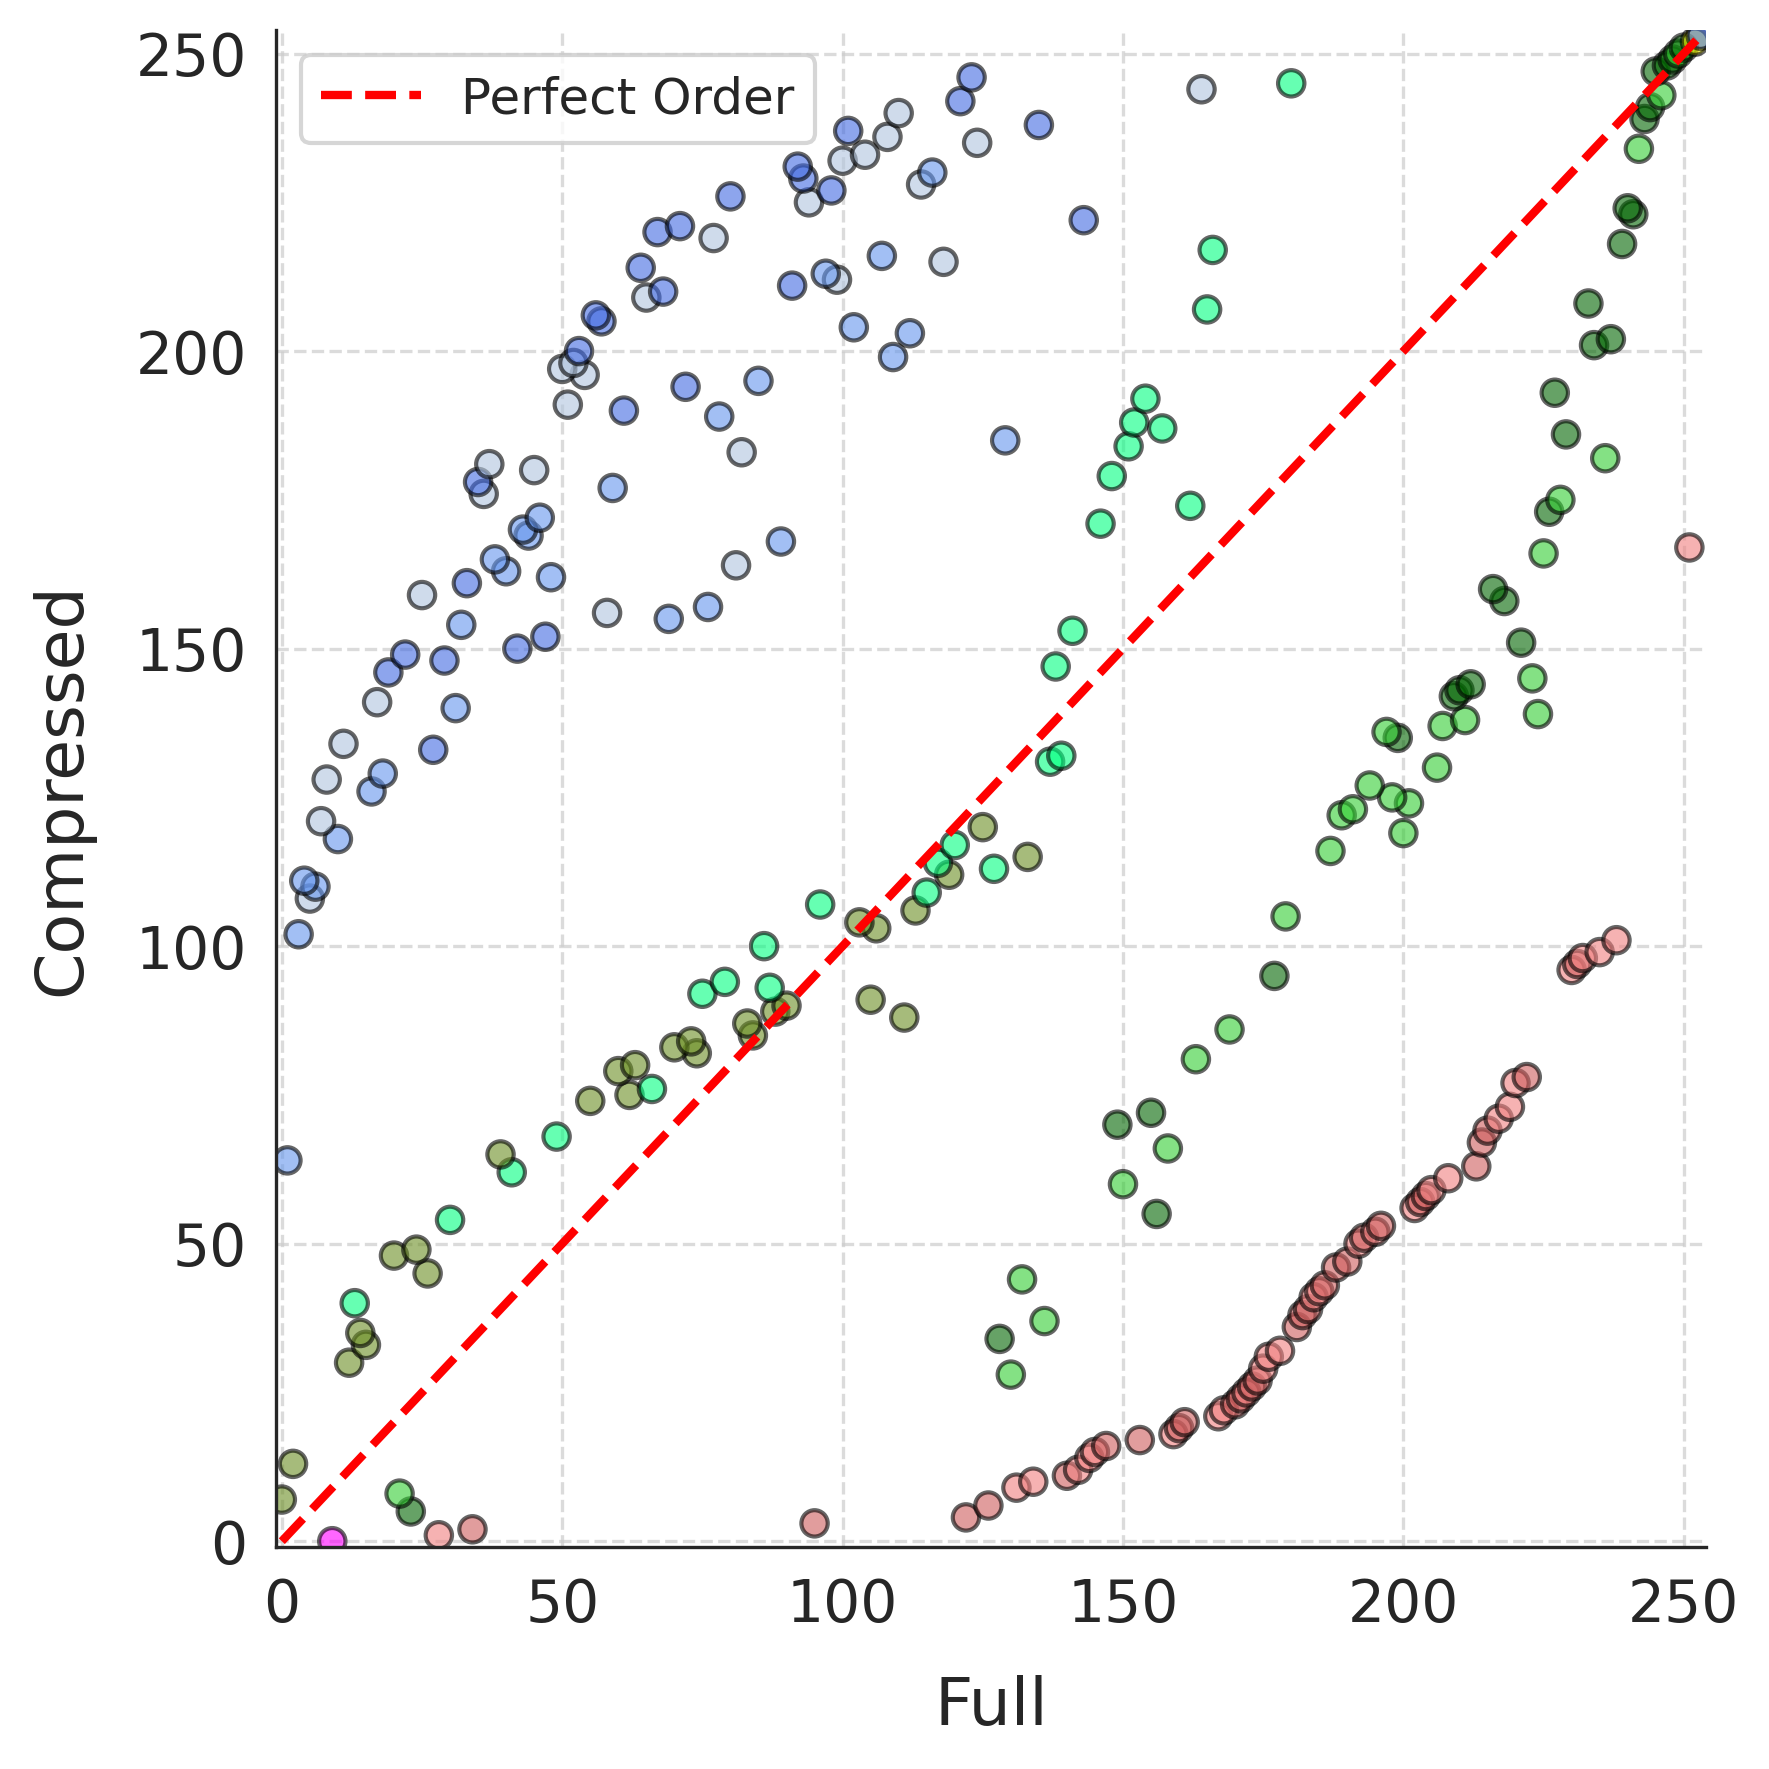

In [21]:
plot_comparison(
    params_x=open_params_file("x/full.txt"),
    params_y=open_params_file("x/k2p16.txt"),
    titles=["Full", "Compressed"],
    in_scope=[
        "embed",
        "mlp",
        "attn",
        "norm",
    ],
    out_scope=[
        "bias",
    ],
    # reverse_x=True,
    # save="figures/weights_ordering_10r10f_2p8.svg",
    # save="figures/norm_ordering_10r10f_2p16.svg",
)